In [140]:
from tqdm import tqdm
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from random import randint
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
%matplotlib inline

Sample size vehicles:  8792
Sample size non-vehicles:  8968
Image size:  (64, 64, 3)
Data type with plt:  <class 'numpy.float32'>
Data type with cv2:  <class 'numpy.uint8'>
Data type with mpimg:  <class 'numpy.float32'>


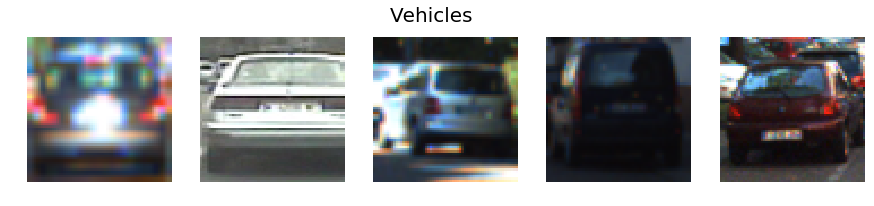

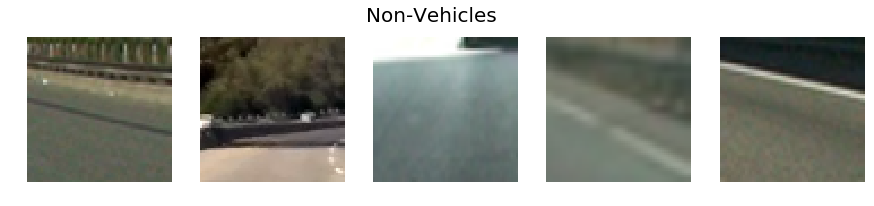

In [9]:
### Explore dataset

## Load images for classifier
images_vehicle = glob.glob('./classifier_images/vehicles/*/*.png')
print ('Sample size vehicles: ', len(images_vehicle))
images_non_vehicle = glob.glob('./classifier_images/non-vehicles/*/*.png')
print ('Sample size non-vehicles: ', len(images_non_vehicle))
print ('Image size: ', plt.imread(images_vehicle[0]).shape)
print ('Data type with plt: ', type(plt.imread(images_vehicle[0])[0,0,0]))
print ('Data type with cv2: ', type(cv2.imread(images_vehicle[0])[0,0,0]))
print ('Data type with mpimg: ', type(mpimg.imread(images_vehicle[0])[0,0,0]))


## Visualize dataset
plt.figure(0, figsize=(15,3))
plt.suptitle('Vehicles', fontsize=20)

# Create list for test images which are used later
test_images = []

for i in range(5):
    rand = randint(0,len(images_vehicle)-1)
    img_vcl = plt.imread(images_vehicle[rand])
    #img_vcl = cv2.cvtColor(img_vcl, cv2.COLOR_BGR2RGB)
    test_images.append(img_vcl)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(img_vcl)
    
plt.savefig('./output_images/vehicle_images.png', bbox_inches='tight')

plt.figure(1, figsize=(15,3))
plt.suptitle('Non-Vehicles', fontsize=20)
for i in range(5):
    rand = randint(0,len(images_non_vehicle)-1)
    img_nvcl = plt.imread(images_non_vehicle[rand])
    #img_nvcl = cv2.cvtColor(img_nvcl, cv2.COLOR_BGR2RGB)
    test_images.append(img_nvcl)
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(img_nvcl)
plt.savefig('./output_images/non_vehicle_images.png', bbox_inches='tight')
    
plt.show()

In [176]:
# Load dataset and return images and labels
def load_dataset(images_vehicle, images_non_vehicle):
    X = []
    y = []
    for path in images_vehicle:
        X.append(plt.imread(path))
        y.append(1)
    for path in images_non_vehicle:
        X.append(plt.imread(path))
        y.append(0)
    return X, y


# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=128, bins_range=(0, 1), feature_vector=True):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    if (feature_vector==True):
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    else:
        return (channel1_hist[0], channel2_hist[0], channel3_hist[0])

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features    

    

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, color_bins=64 ): #hog_channel=0
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        # Read in each one by one
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        # Spatial binning
        bin_features = bin_spatial(image)
        
        # Get color histogram
        hist_features = color_hist(feature_image, nbins=color_bins, feature_vector=False)
        
        # Get Hog features
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = get_hog_features(img_gray, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        feat_concat = np.concatenate((bin_features, hist_features[0], hist_features[1], hist_features[2],hog_features))
        features.append(feat_concat)
    # Return list of feature vectors
    return features



In [4]:
### Load dataset
X,y = load_dataset(images_vehicle, images_non_vehicle)
print ('Images total: ', len(X))
print ('Labels total: ', len(y))

Images total:  17760
Labels total:  17760


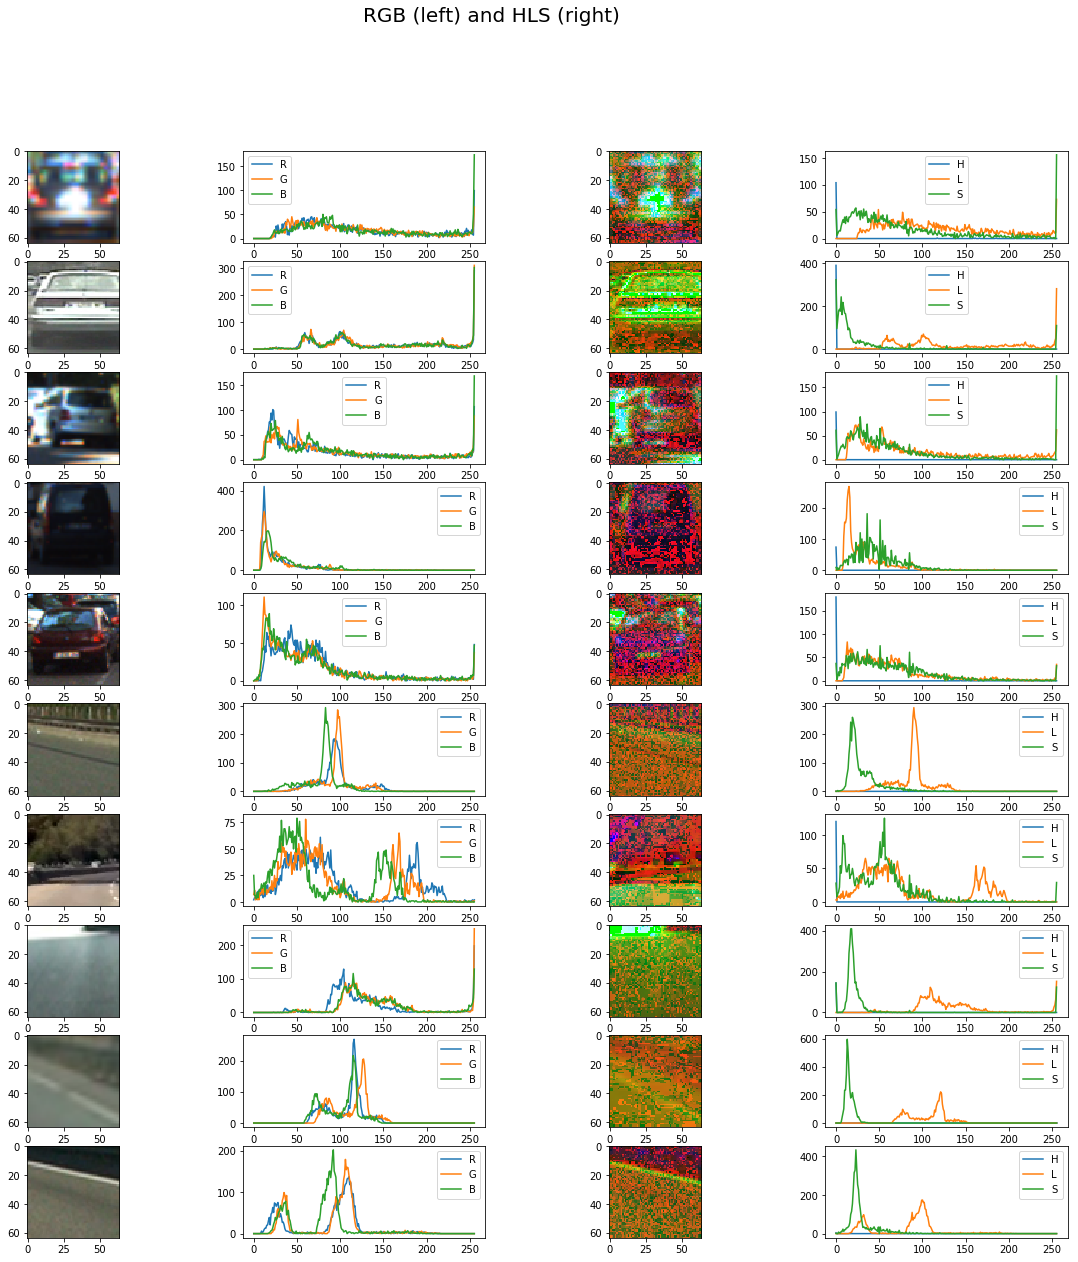

In [71]:
### Visualize color histogram features

plt.figure(figsize=(20,20))
plt.suptitle('RGB (left) and HLS (right)', fontsize=20)
for i, img in enumerate(test_images):
    #img = cv2.cvtColor(X[0], cv2.COLOR_RGB2HSV)
    hist_features = color_hist(img, nbins=256, feature_vector=False)
    plt.subplot(10,4,4*i+1)
    plt.imshow(img)
    plt.subplot(10,4,4*i+2)
    plt.plot(hist_features[0], label='R')
    plt.plot(hist_features[1], label='G')
    plt.plot(hist_features[2], label='B')
    plt.legend()
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hist_features = color_hist(img, nbins=256, feature_vector=False)
    plt.subplot(10,4,4*i+3)
    plt.imshow(img)
    plt.subplot(10,4,4*i+4)
    plt.plot(hist_features[0], label='H')
    plt.plot(hist_features[1], label='L')
    plt.plot(hist_features[2], label='S')
    plt.legend()
plt.savefig('./output_images/histogram_rbg_hsv.png', bbox_inches='tight')

RGB:
- Vehicles and non-vehicles are mostly distinguishable
- 3 color channels are redundant

HSV:
- Hue value seems to make no difference
- Vehicles and non-vehicles mostly distinguishable through S,V

HLS:
- Hue value seems to make no difference
- L channel strongly seperates vehicles and non-vehicles

YUV:
- Terrible, features are the same for every picture

Next step: HOG

feature vector length:  1764


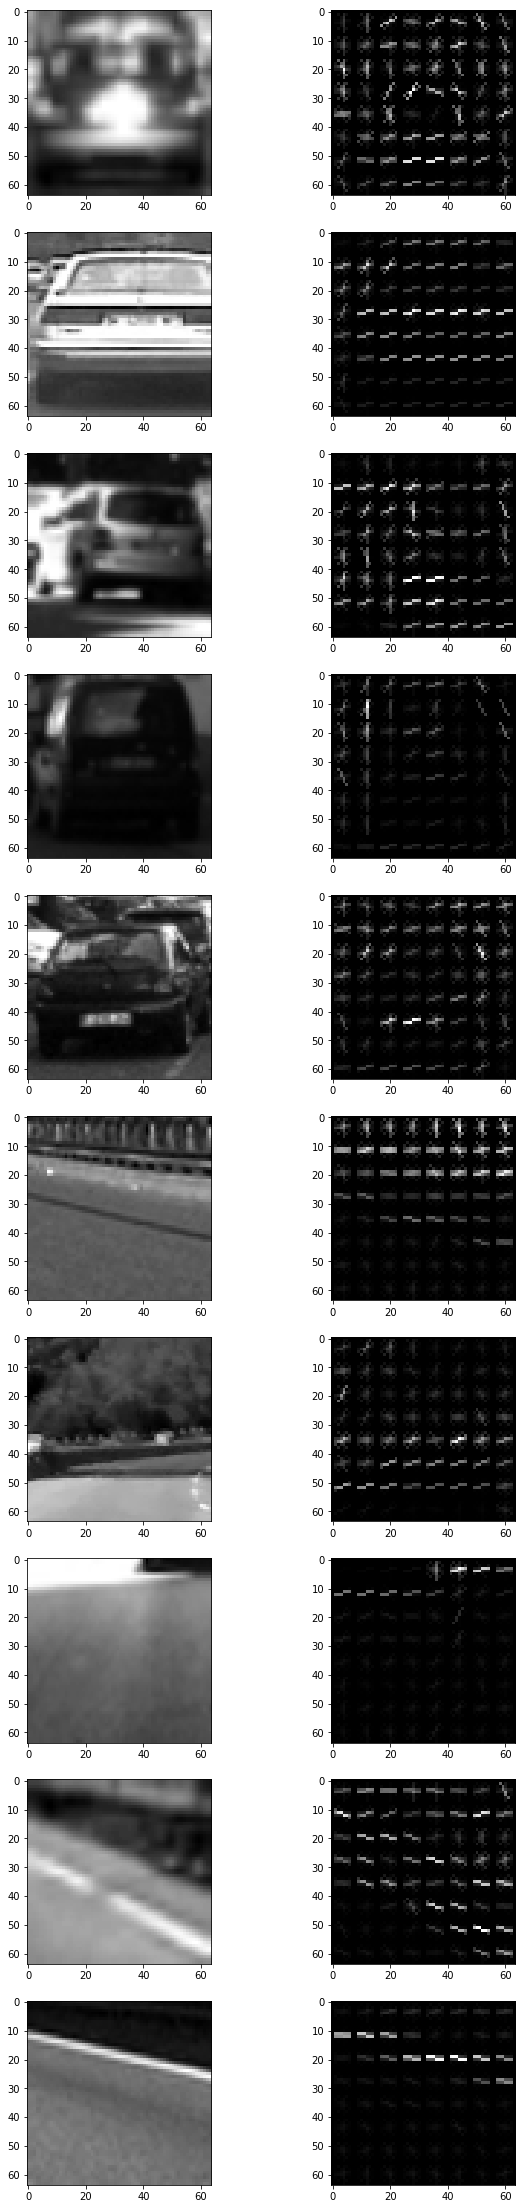

In [169]:
### Visualize HOG

plt.figure(figsize=(10,40))
for i, img in enumerate(test_images):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)
    
    plt.subplot(10,2,2*i+1)
    plt.imshow(img, cmap='gray')
    plt.subplot(10,2,2*i+2)
    plt.imshow(hog_image, cmap='gray')
plt.savefig('./output_images/hog_features.png', bbox_inches='tight')
print ('feature vector length: ', len(features))

100%|██████████| 3552/3552 [00:18<00:00, 190.93it/s]


Train size:  14208
Test size:  3552
Length of feature vector:  2424


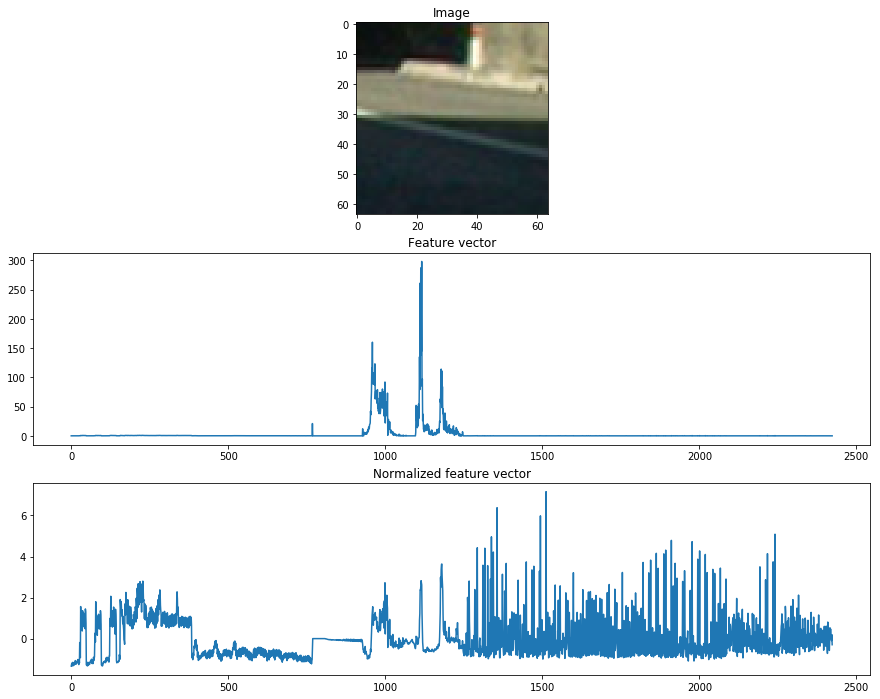

In [181]:
### Preprocess data

X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


features_train = extract_features(X_train, cspace='HSV', orient=6, pix_per_cell=8, cell_per_block=2, color_bins=160 )
features_test = extract_features(X_test, cspace='HSV', orient=6, pix_per_cell=8, cell_per_block=2, color_bins=160)

X_scaler = StandardScaler().fit(features_train)
scaled_features_train = X_scaler.transform(features_train)
scaled_features_test = X_scaler.transform(features_test)

### Visualize feature vector

print ('Train size: ', len(X_train))
print ('Test size: ', len(X_test))
print ('Length of feature vector: ', features_train[0].shape[0])

plt.figure(figsize=(15,12))
rand = randint(0,1000)
sub = plt.subplot(311)
sub.set_title('Image')
plt.imshow(X_train[rand])
sub = plt.subplot(312)
sub.set_title('Feature vector')
plt.plot(features_train[rand])
sub = plt.subplot(313)
sub.set_title('Normalized feature vector')
plt.plot(scaled_features_train[rand])
plt.savefig('./output_images/feature_vector.png', bbox_inches='tight')

In [182]:
### Train classifier
svc = LinearSVC().fit(scaled_features_train, y_train)
print('Test Accuracy: ', svc.score(scaled_features_test, y_test))

Test Accuracy:  0.97972972973


In [159]:
### Save classifier
with open('svc.p', 'wb') as pfile:
    pickle.dump(svc, pfile, pickle.HIGHEST_PROTOCOL)

In [144]:
### Load classifier
with open('svc.p', mode='rb') as pfile:
    clf = pickle.load(pfile)
print('Test Accuracy of SVC = ', clf.score(scaled_features_test, y_test))

Test Accuracy of SVC =  0.982826576577
